In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
%matplotlib inline

### Packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings

In [16]:
data = pd.read_csv("../data/model_data.csv", index_col= False)
data.head(5)

,Delivery_person_Age,Delivery_person_Ratings,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),distance_rest_del_loc,hour,day,weekday_name,TypeOfMeal
0,30,4.7,conditions Sandstorms,Jam,0,Meal,motorcycle,1,No,Metropolitian,34,10.336614,19,20,Sunday,Dinner
1,30,4.7,conditions Sandstorms,Jam,0,Buffet,motorcycle,1,No,Metropolitian,46,5.849717,20,30,Saturday,Dinner
2,30,4.7,conditions Sunny,Low,0,Drinks,motorcycle,1,No,Metropolitian,19,0.974953,9,28,Monday,Breakfast
3,30,4.7,conditions Cloudy,Medium,1,Drinks,motorcycle,1,No,Metropolitian,42,7.799623,18,20,Sunday,Dinner
4,30,4.7,conditions Windy,Jam,0,Snack,motorcycle,1,No,Metropolitian,44,10.724479,19,29,Tuesday,Dinner


In [17]:
data.dtypes

Delivery_person_Age          int64
Delivery_person_Ratings    float64
Weatherconditions           object
Road_traffic_density        object
Vehicle_condition            int64
Type_of_order               object
Type_of_vehicle             object
multiple_deliveries          int64
Festival                    object
City                        object
Time_taken(min)              int64
distance_rest_del_loc      float64
hour                         int64
day                          int64
weekday_name                object
TypeOfMeal                  object
dtype: object

In [18]:
### Features and Predictors(Target)
X = data.drop(['Time_taken(min)'], axis =1)
y = data['Time_taken(min)']

In [20]:
### Splitting the data into Train validation and test
X_train, X_test,y_train ,  y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_Val,  X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.33, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_Val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(35089, 15) (35089,)
(5877, 15) (5877,)
(2896, 15) (2896,)


In [21]:
### Feature Generation
### Convert the categorical features into numerical features

def convert_categorical_numerical(df, categorical_columns):

    encoder = OneHotEncoder(sparse_output = False)
    one_hot_encoded = encoder.fit_transform(df[categorical_columns])
    one_hot_data = pd.DataFrame(one_hot_encoded, 
                                columns = encoder.get_feature_names_out(categorical_columns)) 
    df_rest_index = df.reset_index(drop = True, inplace = False)   
    df_encoded = pd.concat([df_rest_index, one_hot_data], axis =1)
    df_encoded = df_encoded.drop(columns = categorical_columns, axis =1)
    return df_encoded, 



In [22]:
def feature_scaling_numeric_columns(df, numerical_columns):
    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df

In [23]:
def data_preprocessing(data):
    
    categorical_features = X_train.select_dtypes(include=['object']).columns

    data_encoded = convert_categorical_numerical(data, categorical_features)
    numerical_features = data_encoded.select_dtypes(include=['float64', 'int64']).columns
    data_scaled = feature_scaling_numeric_columns(data_encoded, numerical_features)
    return data_scaled

In [24]:
### Applying various ML models
def model_training(X_train, X_test, y_train, y_test, ml_model):
    # Train the model
    ml_model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = ml_model.predict(X_train)
    y_pred_test = ml_model.predict(X_test)

    # Evaluate the model
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = mean_squared_error(y_test, y_pred_test, squared= False) 

    print(f"Model: {ml_model.__class__.__name__}")
    print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")

    print('-' * 50)

    return ml_model, test_mse, test_r2, test_rmse

In [25]:

X_train_pre = data_preprocessing(X_train)
X_Val_pre = data_preprocessing(X_Val)
X_test_pre = data_preprocessing(X_test)


## ML models

In [26]:


# Suppress all warnings
warnings.filterwarnings("ignore")

models = [
    LinearRegression(),
    RandomForestRegressor(n_estimators=100, random_state=42),
    XGBRegressor(n_estimators=100, random_state=42),
    LGBMRegressor(n_estimators=100, random_state=42)
]

# Train and evaluate each model
trained_models = {}
for model in models:
    trained_model, test_mse, r2,rmse = model_training(X_train_pre, X_Val_pre, y_train, y_val, model)
    trained_models[model.__class__.__name__] = {'model': trained_model, 'val_mse': test_mse, 'r2_score': r2, 'rmse': rmse}


for model in models:
    trained_model, test_mse, r2,rmse = model_training(X_train_pre, X_test_pre, y_train, y_test, model)
    trained_models[model.__class__.__name__] = {'model': trained_model, 'test_mse': test_mse, 'r2_score': r2, 'rmse': rmse}



Model: LinearRegression
Train MSE: 35.2891, Test MSE: 1433682431042334817779712.0000, R2 Score: -16105073429720994938880.0000
--------------------------------------------------
Model: RandomForestRegressor
Train MSE: 2.0689, Test MSE: 14.9852, R2 Score: 0.8317
--------------------------------------------------
Model: XGBRegressor
Train MSE: 10.8312, Test MSE: 149.8792, R2 Score: -0.6836
--------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 35089, number of used features: 39
[LightGBM] [Info] Start training from score 26.330189
Model: LGBMRegressor
Train MSE: 13.2006, Test MSE: 14.2887, R2 Score: 0.8

### LightGBM model is performing better 

In [27]:
import  lightgbm as lgb
hyper_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'feature_fraction': 0.9
}

In [28]:
X_train_pre = data_preprocessing(X_train)
X_Val_pre = data_preprocessing(X_Val)
X_test_pre = data_preprocessing(X_test)
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X_train_pre, y_train,
        eval_set=[(X_test_pre, y_test)],
        eval_metric='l1')

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              metric='rmse', objective='regression')

In [29]:

y_pred_test = gbm.predict(X_test_pre)

# Evaluate the model
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared= False) 

print(f"Model: {gbm.__class__.__name__}")
print(f"Test MSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}, RMSE: {test_rmse:.4f}")

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Model: LGBMRegressor
Test MSE: 13.9001, R2 Score: 0.8367, RMSE: 3.7283


In [30]:
def GetMetrics(y, predictions):
    return {'MSE' : mean_squared_error(y, predictions),
            'RMSE' : np.sqrt(mean_squared_error(y, predictions)),
            'MAE': mean_absolute_error(y, predictions)}

In [31]:
### Getting predictions

from sklearn.metrics import explained_variance_score, max_error
Summary = pd.DataFrame(GetMetrics(y = y_test, predictions = y_pred_test), index = ['Score'])

Summary['Explained Variance'] = explained_variance_score(y_test, y_pred_test)
Summary['Max Error'] = max_error(y_test, y_pred_test)

In [32]:
Summary

,MSE,RMSE,MAE,Explained Variance,Max Error
Score,13.900085,3.728282,2.98727,0.83671,14.984886


In [33]:
predictions = y_pred_test

In [34]:
ComparationTable = pd.DataFrame({
    'Real Value' : y_test.values,
    'Model Prediction' : [round(item) for item in y_pred_test],
    'Difference' : y_test.values - [round(item) for item in y_pred_test],
    'Difference %' : np.absolute((y_test.values - [round(item) for item in y_pred_test]) / y_test.values * 100)})

ComparationTable.head()

,Real Value,Model Prediction,Difference,Difference %
0,21,22,-1,4.761905
1,21,24,-3,14.285714
2,11,17,-6,54.545455
3,17,17,0,0.000000
4,17,15,2,11.764706


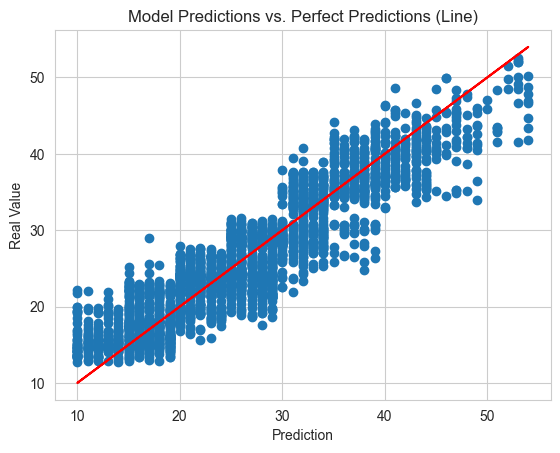

In [35]:
# Our predictions
plt.scatter(y_test, predictions)

# Perfect predictions
plt.plot(y_test, y_test, 'r')
plt.ylabel('Real Value')
plt.xlabel('Prediction')
plt.title('Model Predictions vs. Perfect Predictions (Line)');

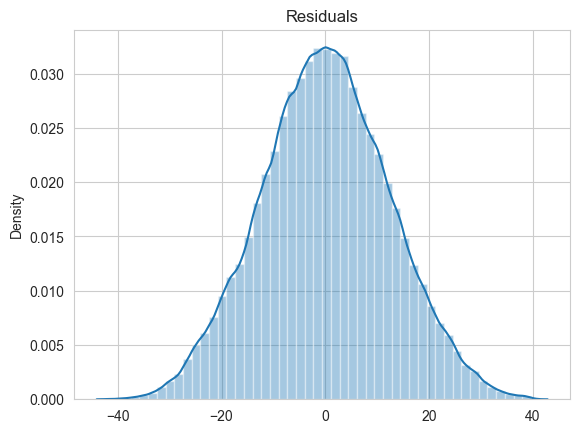

In [36]:
errors = y_test.values.reshape(-1, 1) - predictions
sns.distplot(errors)
plt.title('Residuals');

In [37]:
# Worst predictions
ComparationTable.sort_values(by = 'Difference %', ascending = False).head(10)

,Real Value,Model Prediction,Difference,Difference %
1851,10,22,-12,120.0
1110,10,22,-12,120.0
2893,10,20,-10,100.0
1520,10,20,-10,100.0
2182,11,22,-11,100.0
1737,10,19,-9,90.0
2545,10,19,-9,90.0
2884,10,19,-9,90.0
1146,10,19,-9,90.0
1174,10,19,-9,90.0


In [38]:
# Best predictions
ComparationTable.sort_values(by = 'Difference %', ascending = True).head(10)

,Real Value,Model Prediction,Difference,Difference %
1859,26,26,0,0.0
2197,30,30,0,0.0
1219,23,23,0,0.0
1221,32,32,0,0.0
1222,16,16,0,0.0
2192,14,14,0,0.0
1233,17,17,0,0.0
371,39,39,0,0.0
369,20,20,0,0.0
1249,24,24,0,0.0


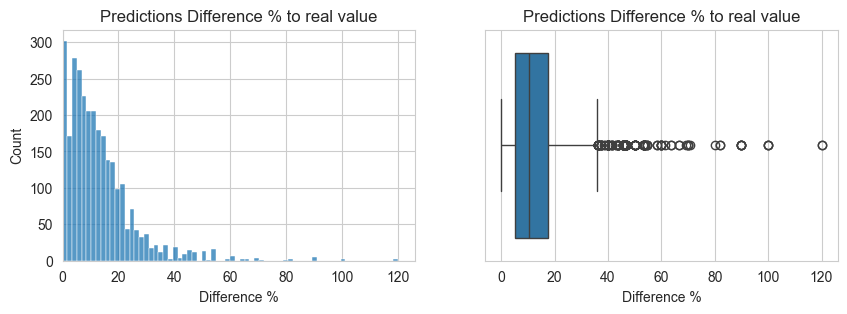

In [39]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 3))
sns.histplot(data = ComparationTable, x = 'Difference %', ax = ax1)
ax1.set_xlim(left = 0)
ax1.set_title('Predictions Difference % to real value')

sns.boxplot(data = ComparationTable, x = 'Difference %', ax = ax2)
ax2.set_title('Predictions Difference % to real value');

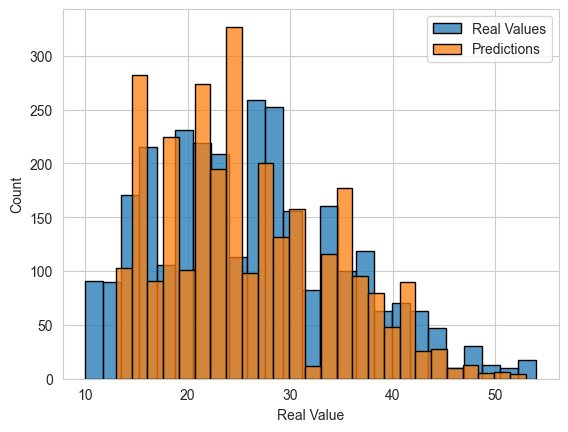

In [40]:
sns.histplot(data = ComparationTable, x = 'Real Value', label = 'Real Values', edgecolor = 'k')
sns.histplot(data = ComparationTable, x = 'Model Prediction', label = 'Predictions', edgecolor = 'k')
plt.legend();

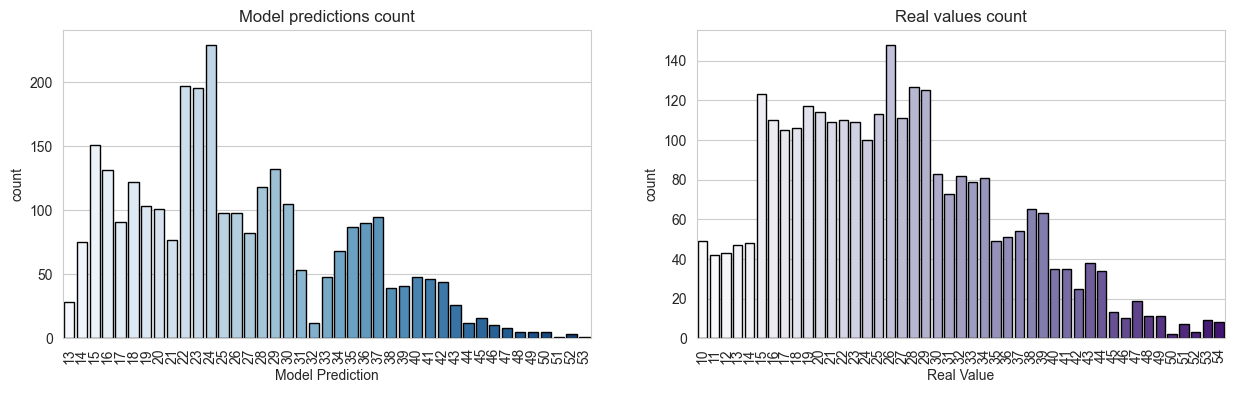

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1,figsize = (15, 4))
sns.countplot(data = ComparationTable, x = 'Model Prediction', ax = ax1, edgecolor = 'k', palette = 'Blues')
ax1.set_title('Model predictions count')
sns.countplot(data = ComparationTable, x = 'Real Value', ax = ax2, edgecolor = 'k', palette = 'Purples')
ax2.set_title('Real values count')

for ax in [ax1, ax2]:
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

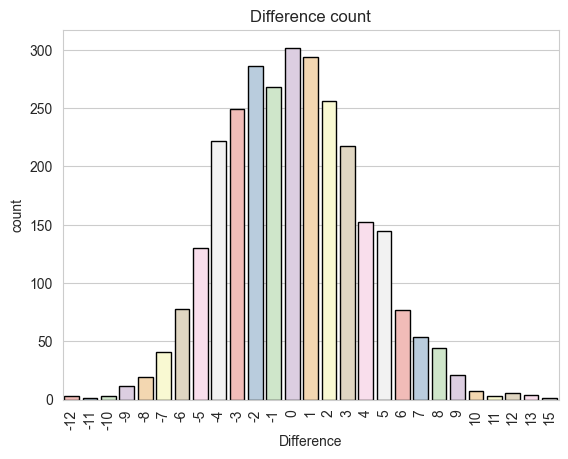

In [42]:
sns.countplot(data = ComparationTable, x = 'Difference', edgecolor = 'k', palette = 'Pastel1')
plt.xticks(rotation = 90)
plt.title('Difference count');

In [43]:
ComparationTable['Difference'].value_counts().to_frame().head(10)

,count
Difference,
0,302
1,294
-2,286
-1,268
2,256
-3,249
-4,222
3,218
4,152


In [47]:
## Saving the model weights
import joblib

# Save the LightGBM model
joblib.dump(gbm, '../model/model.pkl') 

['../model/model.pkl']

In [48]:
model = joblib.load('../model/model.pkl')

In [55]:
import random

index = random.randint(0, len(X))

ToPredict = X.iloc[index]
RealValue = y.iloc[index]

In [74]:
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns

# Step 1: Fit the encoder and scaler on the full training dataset
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()

# Fit on training data
encoder.fit(X_train[categorical_features])
scaler.fit(X_train[numerical_features])

StandardScaler()

In [75]:
def convert_categorical_numerical_single(df, categorical_columns, fitted_encoder):
    # Transform using the pre-fitted encoder
    one_hot_encoded = fitted_encoder.transform(df[categorical_columns])
    one_hot_data = pd.DataFrame(one_hot_encoded, 
                                columns=fitted_encoder.get_feature_names_out(categorical_columns),
                                index=df.index)  # Ensure index matches for concatenation
    
    # Reset index to handle concatenation cleanly
    df_rest_index = df.reset_index(drop=True, inplace=False)
    
    # Concatenate one-hot encoded columns with the rest of the DataFrame
    df_encoded = pd.concat([df_rest_index, one_hot_data], axis=1)
    
    # Drop original categorical columns
    df_encoded = df_encoded.drop(columns=categorical_columns, axis=1)
    return df_encoded

def feature_scaling_numeric_columns_single(df, numerical_columns, fitted_scaler):
    # Scale using the pre-fitted scaler
    df[numerical_columns] = fitted_scaler.transform(df[numerical_columns])
    return df

In [76]:
def data_preprocessing_single(data):
    # Use pre-fitted encoder and scaler
    data_encoded = convert_categorical_numerical_single(data, categorical_features, encoder)
    data_scaled = feature_scaling_numeric_columns_single(data_encoded, numerical_features, scaler)
    return data_scaled

# Step 3: Preprocess a single row
# Assuming your single row is a pandas Series like this:
single_row = pd.Series({
    'Delivery_person_Age': 30,
    'Delivery_person_Ratings': 4.7,
    'Weatherconditions': 'conditions Sandstorms',
    'Road_traffic_density': 'Jam',
    'Vehicle_condition': 0,
    'Type_of_order': 'Meal',
    'Type_of_vehicle': 'motorcycle',
    'multiple_deliveries': 1,
    'Festival': 'No',
    'City': 'Metropolitian',
    'distance_rest_del_loc': 10.336614,
    'hour': 19,
    'day': 20,
    'weekday_name': 'Sunday',
    'TypeOfMeal': 'Dinner'
}, name=0)

# Convert single Series row to DataFrame
single_row_df = single_row.to_frame().T

# Step 4: Preprocess the single row with the pre-fitted encoder and scaler
single_row_preprocessed = data_preprocessing_single(single_row_df)

print(single_row_preprocessed)

   Delivery_person_Age  Delivery_person_Ratings  Vehicle_condition  \
0             0.078474                 0.204664            -1.2237   

   multiple_deliveries  distance_rest_del_loc      hour       day  \
0             0.440993               1.236064  0.328722  0.442046   

   Weatherconditions_conditions Cloudy  Weatherconditions_conditions Fog  \
0                                  0.0                               0.0   

   Weatherconditions_conditions Sandstorms  \
0                                      1.0   

   Weatherconditions_conditions Stormy  Weatherconditions_conditions Sunny  \
0                                  0.0                                 0.0   

   Weatherconditions_conditions Windy  Road_traffic_density_High   \
0                                 0.0                         0.0   

   Road_traffic_density_Jam   Road_traffic_density_Low   \
0                        0.0                        0.0   

   Road_traffic_density_Medium   Type_of_order_Buffet   Typ

In [77]:
single_row_preprocessed.shape

(1, 39)

In [79]:
pred_value = model.predict(single_row_preprocessed)
pred_value

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


array([43.72212754])

In [80]:
RealValue

np.int64(38)